<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por palabras

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [ ]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, SimpleRNN, GRU
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# descargar de textos.info
import urllib.request

# Para leer y parsear el texto en HTML de wikipedia
import bs4 as bs

import pandas as pd
import requests
from bs4 import BeautifulSoup

### Datos


Para este desafío se utilizó un dataset de libros de Horacio Quiroga obtenidos desde el sitio *textos.info*. A diferencia del presentado en clase, este no se divide en versos y además tiene una longitud mayor, ya que es es la concatenación de una serie de cuentos del autor.

Se mantendrán celdas y comentarios del notebook original para los casos que corresponda, ya que son útiles para entender el problema en su totalidad.

In [ ]:
raw_html = urllib.request.urlopen('https://www.textos.info/horacio-quiroga/cuentos-de-amor-de-locura-y-de-muerte/ebook')
raw_html = raw_html.read()

# se parsea el dataset con el parser "lxml"
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Se buscan todos los párrafos del HTML (quedan como lista)
article_paragraphs = article_html.find_all('p')

article_text = ''
for para in article_paragraphs:
    article_text += para.text + ' '

# Se pasa el texto a minúsculas y se quitan saltos de línea
article_text = article_text.lower()
article_text = article_text.replace('\n', ' ')
article_text = article_text.replace('\r', ' ')

In [ ]:
# Se muestran los primeros 1000 caracteres
article_text[:1000]

' primavera era el martes de carnaval. nébel acababa de entrar en el corso, ya al  oscurecer, y mientras deshacía un paquete de serpentinas, miró al  carruaje de delante. extrañado de una cara que no había visto la tarde  anterior, preguntó a sus compañeros: —¿quién es? no parece fea. —¡un demonio! es lindísima. creo que sobrina, o cosa así, del doctor    arrizabalaga. llegó ayer, me parece…  nébel fijó entonces atentamente los ojos en la hermosa criatura. era  una chica muy joven aún, acaso no más de catorce años, pero  completamente núbil. tenía, bajo el cabello muy oscuro, un rostro de  suprema blancura, de ese blanco mate y raso que es patrimonio  exclusivo de los cutis muy finos. ojos azules, largos, perdiéndose  hacia las sienes en el cerco de sus negras pestañas. acaso un poco  separados, lo que da, bajo una frente tersa, aire de mucha nobleza o  de gran terquedad. pero sus ojos, así, llenaban aquel semblante en  flor con la luz de su belleza. y al sentirlos nébel detenidos un  

In [ ]:
import re
import nltk
nltk.download('punkt')

from nltk.tokenize import sent_tokenize

# Se divide el texto en oraciones
sentences = sent_tokenize(article_text, language='spanish')

# Se muestran las tres primeras oraciones resultantes
sentences[:10]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


[' primavera era el martes de carnaval.',
 'nébel acababa de entrar en el corso, ya al  oscurecer, y mientras deshacía un paquete de serpentinas, miró al  carruaje de delante.',
 'extrañado de una cara que no había visto la tarde  anterior, preguntó a sus compañeros: —¿quién es?',
 'no parece fea.',
 '—¡un demonio!',
 'es lindísima.',
 'creo que sobrina, o cosa así, del doctor    arrizabalaga.',
 'llegó ayer, me parece…  nébel fijó entonces atentamente los ojos en la hermosa criatura.',
 'era  una chica muy joven aún, acaso no más de catorce años, pero  completamente núbil.',
 'tenía, bajo el cabello muy oscuro, un rostro de  suprema blancura, de ese blanco mate y raso que es patrimonio  exclusivo de los cutis muy finos.']

En la siguiente celda se quitan caracteres especiales que no serán considerados en este ejercicio por simplicidad. Esto incluye todos aquellos que no son letras ni espacios. Además se reemplazan espacios consecutivos por un único espacio y se hace trim de cada sentencia.

In [ ]:
# Se reemplazan caracteres que no sean letras del alfabeto
cleaned_sentences = [re.sub(r'[^\w\s]', ' ', sentence) for sentence in sentences]

# Se reemplazan espacios consecutivos por un único espacio
cleaned_sentences = [re.sub(r'\s+', ' ', sentence).strip() for sentence in cleaned_sentences]

# Se muestran las primeras 10 sentencias arregladas
cleaned_sentences[:10]

['primavera era el martes de carnaval',
 'nébel acababa de entrar en el corso ya al oscurecer y mientras deshacía un paquete de serpentinas miró al carruaje de delante',
 'extrañado de una cara que no había visto la tarde anterior preguntó a sus compañeros quién es',
 'no parece fea',
 'un demonio',
 'es lindísima',
 'creo que sobrina o cosa así del doctor arrizabalaga',
 'llegó ayer me parece nébel fijó entonces atentamente los ojos en la hermosa criatura',
 'era una chica muy joven aún acaso no más de catorce años pero completamente núbil',
 'tenía bajo el cabello muy oscuro un rostro de suprema blancura de ese blanco mate y raso que es patrimonio exclusivo de los cutis muy finos']

In [ ]:
print("Cantidad de documentos:", len(cleaned_sentences))

Cantidad de documentos: 3384


### Elegir el tamaño del contexto

In [ ]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding


In [ ]:
# Se segmenta el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence) for sentence in cleaned_sentences]

In [ ]:
segmented_sentences[6]

['creo', 'que', 'sobrina', 'o', 'cosa', 'así', 'del', 'doctor', 'arrizabalaga']

In [ ]:
# Se calcula la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

(array([584., 739., 646., 401., 409., 232., 139.,  84.,  51.,  42.,  24.,
         14.,   0.,   6.,   5.,   3.,   2.,   1.,   1.,   1.]),
 array([ 0. ,  4.7,  9.4, 14.1, 18.8, 23.5, 28.2, 32.9, 37.6, 42.3, 47. ,
        51.7, 56.4, 61.1, 65.8, 70.5, 75.2, 79.9, 84.6, 89.3, 94. ]),
 <BarContainer object of 20 artists>)

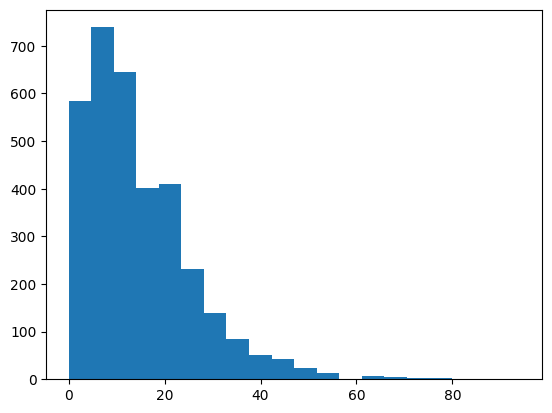

In [ ]:
# Se visualiza su distribución
plt.hist(length_sentences,bins=20)

A partir de esta distribución de longitudes de secuencias, se utilizó el percentil 90 para determinar el máximo tamaño de contexto que utilizará el modelo. También se probaron valores más pequeños, no obteniendo mejoras notorias o incluso peores en los entrenamientos.

In [ ]:
# el -1 es porque el último token será el target
max_context_size = int(np.percentile(length_sentences, 90)-1)

print(f'max_context_size: {max_context_size}')

max_context_size: 28


###  Tokenizar

Se tokenizan las sentencias de forma de asignarle un número único a cada palabra.

In [ ]:
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [ ]:
tokenized_sentences[0]

[3480, 35, 4, 2197, 1, 2198]

In [ ]:
segmented_sentences[0]

['primavera', 'era', 'el', 'martes', 'de', 'carnaval']

### Organizando y estructurando el dataset

En este punto tenemos en la variable `tokenized_sentences` las oraciones tokenizadas. Se realiza la división de las mismas en dos subconjuntos de entrenamiento y validación. Este último se utilizará para medir la calidad de la generación de secuencias con la métrica Perplejidad.

In [ ]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)

Vamos a splitear las oraciones que tienen tamaño mayor al contexto máximo, para generarnos más secuencias de entrenamiento. Este paso puede obviarse si el tamaño de contexto máximo es muy grande.

In [ ]:
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)


In [ ]:
len(tok_sent)

5513

Ahora aumentamos los datos aprovechando que de una secuencia grande se pueden generar varias más pequeñas:

- *La hermosa casa en el prado*
- *La hermosa*
- *La hermosa casa*
- *La hermosa casa en*
- *La hermosa casa en el*
- *La hermosa casa en el prado*

In [ ]:
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))


In [ ]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [ ]:
train_seqs.shape

(112872, 29)

In [ ]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,1:]

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

In [ ]:
y.shape

(112872, 28)

In [ ]:
# Palabras del vocabulario
tok.index_word

{1: 'de',
 2: 'la',
 3: 'y',
 4: 'el',
 5: 'a',
 6: 'que',
 7: 'en',
 8: 'no',
 9: 'su',
 10: 'se',
 11: 'un',
 12: 'los',
 13: 'con',
 14: 'al',
 15: 'por',
 16: 'una',
 17: 'lo',
 18: 'las',
 19: 'me',
 20: 'más',
 21: 'del',
 22: 'pero',
 23: 'para',
 24: 'es',
 25: 'había',
 26: 'mi',
 27: 'como',
 28: 'le',
 29: 'sus',
 30: 'sin',
 31: 'qué',
 32: 'ya',
 33: 'ojos',
 34: 'sobre',
 35: 'era',
 36: 'yo',
 37: 'vez',
 38: 'todo',
 39: 'si',
 40: 'cuando',
 41: 'dos',
 42: 'ella',
 43: 'sí',
 44: 'aún',
 45: 'bien',
 46: 'nébel',
 47: 'él',
 48: 'día',
 49: 'noche',
 50: 'hasta',
 51: 'maría',
 52: 'después',
 53: 'fin',
 54: 'mí',
 55: 'muy',
 56: 'o',
 57: 'nada',
 58: 'entonces',
 59: 'te',
 60: 'momento',
 61: 'poco',
 62: 'hombre',
 63: 'cabeza',
 64: 'fué',
 65: 'esa',
 66: 'casa',
 67: 'esto',
 68: 'esta',
 69: 'madre',
 70: 'usted',
 71: 'ha',
 72: 'mujer',
 73: 'tenía',
 74: 'desde',
 75: 'ahora',
 76: 'siempre',
 77: 'eso',
 78: 'ese',
 79: 'tres',
 80: 'nuevo',
 81: 'así',


In [ ]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

8244

In [ ]:
# El índice para cada palabra
# El algoritmo las ordena de las más populares a las menos populares
print(tok.word_index)

{'de': 1, 'la': 2, 'y': 3, 'el': 4, 'a': 5, 'que': 6, 'en': 7, 'no': 8, 'su': 9, 'se': 10, 'un': 11, 'los': 12, 'con': 13, 'al': 14, 'por': 15, 'una': 16, 'lo': 17, 'las': 18, 'me': 19, 'más': 20, 'del': 21, 'pero': 22, 'para': 23, 'es': 24, 'había': 25, 'mi': 26, 'como': 27, 'le': 28, 'sus': 29, 'sin': 30, 'qué': 31, 'ya': 32, 'ojos': 33, 'sobre': 34, 'era': 35, 'yo': 36, 'vez': 37, 'todo': 38, 'si': 39, 'cuando': 40, 'dos': 41, 'ella': 42, 'sí': 43, 'aún': 44, 'bien': 45, 'nébel': 46, 'él': 47, 'día': 48, 'noche': 49, 'hasta': 50, 'maría': 51, 'después': 52, 'fin': 53, 'mí': 54, 'muy': 55, 'o': 56, 'nada': 57, 'entonces': 58, 'te': 59, 'momento': 60, 'poco': 61, 'hombre': 62, 'cabeza': 63, 'fué': 64, 'esa': 65, 'casa': 66, 'esto': 67, 'esta': 68, 'madre': 69, 'usted': 70, 'ha': 71, 'mujer': 72, 'tenía': 73, 'desde': 74, 'ahora': 75, 'siempre': 76, 'eso': 77, 'ese': 78, 'tres': 79, 'nuevo': 80, 'así': 81, 'ni': 82, 'mismo': 83, 'amor': 84, 'dijo': 85, 'días': 86, 'está': 87, 'otro': 8

In [ ]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'era': 136, 'martes': 2, 'de': 1428, 'el': 1048, 'primavera': 1, 'carnaval': 2, 'un': 576, 'en': 888, 'deshacía': 2, 'nébel': 107, 'acababa': 14, 'oscurecer': 1, 'paquete': 5, 'ya': 161, 'carruaje': 5, 'corso': 3, 'serpentinas': 3, 'miró': 41, 'mientras': 46, 'y': 1189, 'al': 378, 'delante': 16, 'entrar': 7, 'preguntó': 21, 'compañeros': 12, 'la': 1155, 'tarde': 55, 'extrañado': 4, 'quién': 17, 'sus': 168, 'había': 220, 'anterior': 19, 'visto': 27, 'una': 361, 'que': 974, 'cara': 19, 'es': 232, 'a': 985, 'no': 717, 'parece': 21, 'fea': 2, 'demonio': 5, 'lindísima': 2, 'creo': 25, 'cosa': 34, 'sobrina': 1, 'del': 288, 'arrizabalaga': 13, 'doctor': 6, 'o': 79, 'así': 62, 'ayer': 4, 'me': 317, 'atentamente': 7, 'llegó': 21, 'los': 504, 'entonces': 80, 'fijó': 9, 'ojos': 147, 'hermosa': 5, 'criatura': 12, 'pero': 321, 'chica': 5, 'catorce': 6, 'completamente': 5, 'muy': 79, 'acaso': 18, 'años': 53, 'más': 306, 'joven': 24, 'aún': 113, 'núbil': 1, 'finos': 1, 'ro


### Definir el modelo

En este notebook se ensayarán tres arquitecturas diferentes para realizar el entrenamiento. Además de revisar el comportamiento de la red **LSTM** mostrada en clase para el nuevo corpus, se probaron alternativas con SimpleRNN y GRU para analizar si hay mejoras con respecto a la perplejidad a lo largo de las épocas.

En todos los casos se probarán diferentes tamaños, pero no se guardará registro de todas las pruebas debido a los tiempos de ejecución y las limitaciones en el uso de GPU, que sólo permiten realizar unas pocas pruebas al día.

In [ ]:
model_LSTM = Sequential()

# la primera capa es de embedding entrenable. Recordar que se puede variar el tamaño
# del embedding a entrenar
model_LSTM.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_shape=(None,)))

model_LSTM.add(LSTM(100, return_sequences=True))
model_LSTM.add(Dropout(0.2))

model_LSTM.add(LSTM(100, return_sequences=True))
model_LSTM.add(Dropout(0.2))

# Predicción de clasificación con softmax
# La salida es del tamaño del vocabulario
model_LSTM.add(Dense(vocab_size+1, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model_LSTM.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model_LSTM.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, None, 50)            │         412,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, None, 100)           │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, None, 100)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, None, 100)           │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, None, 100)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, None, 8245)          │         832,745 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,385,795 (5.29 MB)

 Trainable params: 1,385,795 (5.29 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_simpleRNN = Sequential()

# la primera capa es de embedding entrenable. Recordar que se puede variar el tamaño
# del embedding a entrenar
model_simpleRNN.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_shape=(None,)))

# Capas SimpleRNN
model_simpleRNN.add(SimpleRNN(100, return_sequences=True))
model_simpleRNN.add(Dropout(0.2))

model_simpleRNN.add(SimpleRNN(100, return_sequences=True))
#model_simpleRNN.add(Dropout(0.2))

# Capa de salida: clasificación con softmax
model_simpleRNN.add(Dense(vocab_size + 1, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model_simpleRNN.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model_simpleRNN.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, None, 50)            │         412,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, None, 100)           │          15,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, None, 100)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, None, 100)           │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, None, 8245)          │         832,745 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,280,195 (4.88 MB)

 Trainable params: 1,280,195 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam


model_GRU = Sequential()

# Capa de embedding
model_GRU.add(Embedding(input_dim=vocab_size + 1, output_dim=50, input_shape=(None,)))

# Capa GRU
model_GRU.add(GRU(100, return_sequences=True))
model_GRU.add(Dropout(0.2))

# Segunda capa GRU
model_GRU.add(GRU(100, return_sequences=True))
model_GRU.add(Dropout(0.2))

# Capa de salida: clasificación con softmax
model_GRU.add(Dense(vocab_size + 1, activation='softmax'))

# Compilar el modelo
model_GRU.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model_GRU.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, None, 50)            │         412,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, None, 100)           │          45,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, None, 100)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, None, 100)           │          60,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, None, 100)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, None, 8245)          │         832,745 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,351,195 (5.15 MB)

 Trainable params: 1,351,195 (5.15 MB)

 Non-trainable params: 0 (0.00 B)

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Importante**: El método ***on_epoch_end*** implementado originalmente no funcionaba adecuadamente en Colab para textos grandes como el que se está utilizando. El problema se daba porque guardaba todas las predicciones del conjunto de validación en memoria para realizar el cálculo de la perplejidad, provocando un error por superar el máximo permitido. Por lo tanto, se optó por una implementación por batches más pequeños que no sufre este problema.

In [ ]:
import numpy as np

class PplCallback(keras.callbacks.Callback):
    def __init__(self, val_data, history_ppl, model_name, patience=5):
        self.val_data = val_data
        self.target = []
        self.padded = []
        count = 0
        self.info = []
        self.history_ppl = history_ppl
        self.min_score = np.inf
        self.patience_counter = 0
        self.patience = patience
        self.model_name = model_name

        # Procesar secuencias de validación
        for seq in self.val_data:
            len_seq = len(seq)
            subseq = [seq[:i] for i in range(len_seq)]
            self.target.extend([seq[i] for i in range(len_seq)])

            if len(subseq) != 0:
                self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))
                self.info.append((count, count + len_seq))
                count += len_seq

        self.padded = np.vstack(self.padded)

    def on_epoch_end(self, epoch, logs=None):
        scores = []
        batch_size = 32  # Tamaño del lote para las predicciones

        # Se realizan predicciones por lotes para el cálculo de la perplejidad
        for start_idx, (start, end) in enumerate(self.info):

            # Se selecciona el lote de secuencias correspondiente
            batch_padded = self.padded[start:end]
            num_batches = int(np.ceil(len(batch_padded) / batch_size))

            # Se calculan las probabilidades para cada lote
            probs = []
            for i in range(num_batches):
                batch_start = i * batch_size
                batch_end = min((i + 1) * batch_size, len(batch_padded))
                batch_predictions = self.model.predict(batch_padded[batch_start:batch_end], verbose=0)

                # Se recopilan las probabilidades para los términos target
                for idx_seq, idx_vocab in zip(range(batch_start, batch_end), self.target[start:end]):
                    probs.append(batch_predictions[idx_seq - batch_start, -1, idx_vocab])

            # Se calcula la perplejidad para la secuencia actual
            scores.append(np.exp(-np.sum(np.log(probs)) / (end - start)))

            # Se limpian variables para liberar memoria
            del batch_padded, batch_predictions, probs

        # Se promedian todos los scores
        current_score = np.mean(scores)
        self.history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # Se verifica si se debe detener el entrenamiento
        if current_score < self.min_score:
            self.min_score = current_score
            self.model.save(f'{self.model_name}.keras')
            print("Saved new model!")
            self.patience_counter = 0
        else:
            self.patience_counter += 1
            if self.patience_counter == self.patience:
                print("Stopping training...")
                self.model.stop_training = True


### Entrenamiento

A continuación se realiza el entrenamiento para los tres modelos propuestos. Se hicieron muchas pruebas con distintas arquitecturas, como por ejemplo sumando capas, o cambiando el número de neuronas de cada una. Incluso se aumentó el tamaño de los embeddings.

También se fue alternando entre el optimizador Adam y RMSProp, siendo este último el que presentaba mejor convergencia.

Se pudo notar que las arquitecturas más complejas presentaban una convergencia muy lenta que hacía inviable el entrenamiento a través de Colab debido a las limitaciones antes mencionadas. Por lo tanto, se mantuvieron los parámetros en el orden de lo que se vio en clase dado que los resultados fueron los más aceptables.

Estos resultados, en cuanto a la métrica de Perplejidad, no fueron los mejores pero aún así permiten visualizar algunos ejemplos interesantes.

In [ ]:
history_ppl_LSTM = []
hist_LSTM = model_LSTM.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val, history_ppl_LSTM, model_name='model_LSTM')], batch_size=64)


Epoch 1/20
1763/1764 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.0205
 mean perplexity: 9954.580568620926 

Saved new model!
1764/1764 ━━━━━━━━━━━━━━━━━━━━ 91s 48ms/step - loss: 4.0200
Epoch 2/20
1764/1764 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.2479
 mean perplexity: 7949.773758997607 

Saved new model!
1764/1764 ━━━━━━━━━━━━━━━━━━━━ 132s 45ms/step - loss: 3.2479
Epoch 3/20
1763/1764 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.0236
 mean perplexity: 14943.843727852463 

1764/1764 ━━━━━━━━━━━━━━━━━━━━ 83s 45ms/step - loss: 3.0236
Epoch 4/20
1763/1764 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.9090
 mean perplexity: 4421.435992905586 

Saved new model!
1764/1764 ━━━━━━━━━━━━━━━━━━━━ 82s 46ms/step - loss: 2.9090
Epoch 5/20
1761/1764 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.8323
 mean perplexity: 4025.3067526863642 

Saved new model!
1764/1764 ━━━━━━━━━━━━━━━━━━━━ 80s 45ms/step - loss: 2.8323
Epoch 6/20
1762/1764 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.7656
 mean perplexity: 3

In [ ]:
history_ppl_simpleRNN = []
hist_simpleRNN = model_simpleRNN.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val, history_ppl_simpleRNN, model_name='model_simpleRNN')], batch_size=64)

Epoch 1/20
1764/1764 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.7546
 mean perplexity: 27363.10251075266 

Saved new model!
1764/1764 ━━━━━━━━━━━━━━━━━━━━ 109s 59ms/step - loss: 3.7543
Epoch 2/20
1762/1764 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.4850
 mean perplexity: 54267.90092655675 

1764/1764 ━━━━━━━━━━━━━━━━━━━━ 115s 46ms/step - loss: 2.4846
Epoch 3/20
1762/1764 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.7691
 mean perplexity: 23438.709235843842 

Saved new model!
1764/1764 ━━━━━━━━━━━━━━━━━━━━ 82s 46ms/step - loss: 1.7689
Epoch 4/20
1762/1764 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.3253
 mean perplexity: 23154.97687280098 

Saved new model!
1764/1764 ━━━━━━━━━━━━━━━━━━━━ 81s 46ms/step - loss: 1.3252
Epoch 5/20
1762/1764 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.0943
 mean perplexity: 21609.74414284076 

Saved new model!
1764/1764 ━━━━━━━━━━━━━━━━━━━━ 80s 45ms/step - loss: 1.0943
Epoch 6/20
1761/1764 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.9712
 mean perplexity: 1

In [ ]:
history_ppl_GRU = []
hist_GRU = model_GRU.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val, history_ppl_GRU, model_name='model_GRU')], batch_size=64)

Epoch 1/20
1762/1764 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.7631
 mean perplexity: 29154.604061538732 

Saved new model!
1764/1764 ━━━━━━━━━━━━━━━━━━━━ 80s 44ms/step - loss: 3.7622
Epoch 2/20
1761/1764 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.8664
 mean perplexity: 6641.324505028864 

Saved new model!
1764/1764 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - loss: 2.8663
Epoch 3/20
1763/1764 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.7090
 mean perplexity: 6178.398842105952 

Saved new model!
1764/1764 ━━━━━━━━━━━━━━━━━━━━ 83s 44ms/step - loss: 2.7090
Epoch 4/20
1762/1764 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.5982
 mean perplexity: 7260.493439019934 

1764/1764 ━━━━━━━━━━━━━━━━━━━━ 78s 44ms/step - loss: 2.5981
Epoch 5/20
1764/1764 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.4966
 mean perplexity: 7158.269312977903 

1764/1764 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - loss: 2.4966
Epoch 6/20
1761/1764 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.4058
 mean perplexity: 7766.4990065224565 


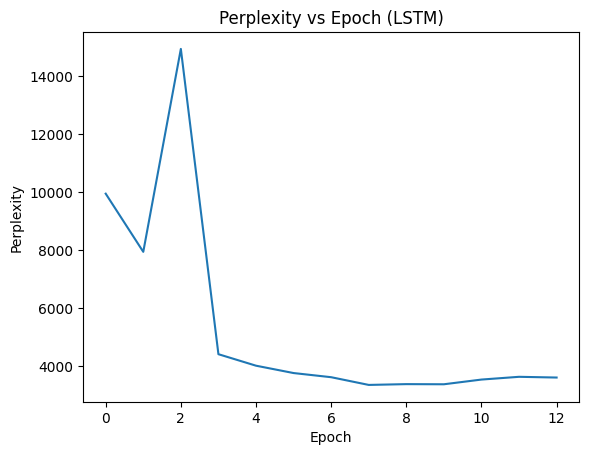

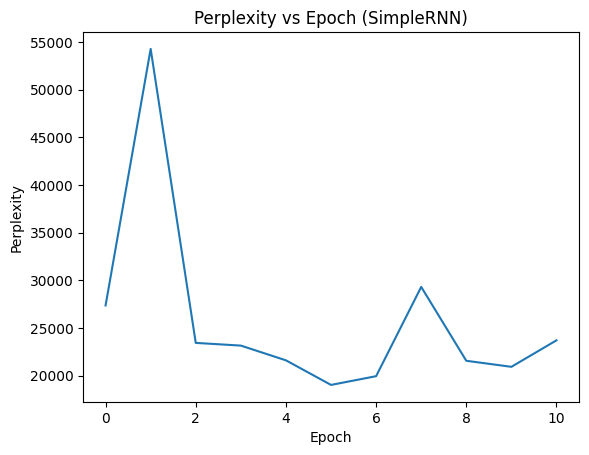

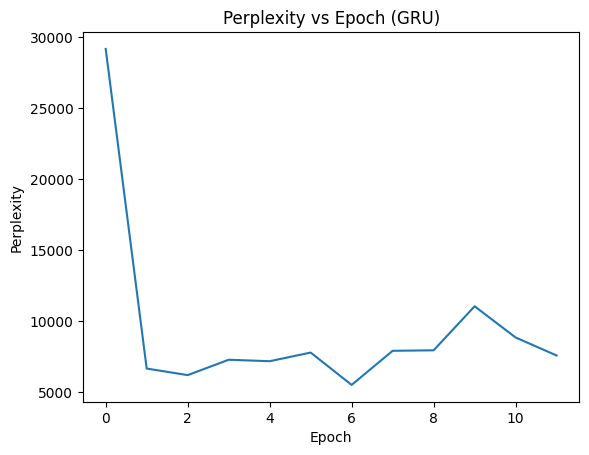

In [ ]:
plt.plot(history_ppl_LSTM)
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Perplexity vs Epoch (LSTM)')
plt.show()

plt.plot(history_ppl_simpleRNN)
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Perplexity vs Epoch (SimpleRNN)')
plt.show()

plt.plot(history_ppl_GRU)
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Perplexity vs Epoch (GRU)')
plt.show()

Como se puede observar en los gráficos, en los tres entrenamientos se puede notar que la perplejidad baja mucho en las primeras épocas dejando de aprender rápidamente. Seguramente aplicando mejores técnicas de regularización la situación pueda mejorar algo, aunque seguramente el corpus utilizado también tenga cierta influencia en este comportamiento.

In [ ]:
# Se cargan los mejores modelos guardados
model_LSTM = keras.models.load_model('model_LSTM.keras')
model_simpleRNN = keras.models.load_model('model_simpleRNN.keras')
model_GRU = keras.models.load_model('model_GRU.keras')


### Predicción de próxima palabra

Las siguientes dos celdas fueron utilizadas para obtener predicciones del modelo de forma ágil con una interfaz gráfica más amigable (usando Gradio).

De todas formas se incluyen algunas pruebas realizadas invocando simplemente la función *model_response*.

In [ ]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.0/94.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 10.5 MB/s eta 0:00:00


In [ ]:
import gradio as gr

def model_response(human_text, model=model_LSTM):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://2116c884be47ec9229.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://2116c884be47ec9229.gradio.live


In [ ]:
print(f'Respuesta LSTM: { model_response("Era una casa", model_LSTM) }')
print(f'Respuesta SimpleRNN: {model_response("Era una casa", model_simpleRNN)}')
print(f'Respuesta GRU: {model_response("Era una casa", model_GRU)}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Respuesta LSTM: Era una casa en
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Respuesta SimpleRNN: Era una casa y
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Respuesta GRU: Era una casa de


In [ ]:
print(f'Respuesta LSTM: { model_response("El perro que estaba en", model_LSTM) }')
print(f'Respuesta SimpleRNN: {model_response("El perro que estaba en", model_simpleRNN)}')
print(f'Respuesta GRU: {model_response("El perro que estaba en", model_GRU)}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Respuesta LSTM: El perro que estaba en la
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Respuesta SimpleRNN: El perro que estaba en él
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Respuesta GRU: El perro que estaba en la


Tanto LSTM como GRU presentan buenos resultados en los ejemplos, mientras que SimpleRNN se mostró algo más errático.

### Generación de secuencias

En esta sección se analizará la generación de secuencias para los tres modelos entrenados.

In [ ]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	  # generate a fixed number of words
    for _ in range(n_words):
		  # Tokenizamos
      encoded = tokenizer.texts_to_sequences([output_text])[0]

		  # Si tienen distinto largo
      encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		  # Predicción softmax
      y_hat = np.argmax(model.predict(encoded)[0,-1,:])

      # Vamos concatenando las predicciones
      out_word = ''

      # Debemos buscar en el vocabulario la palabra
      # que corresopnde al indice (y_hat) predicho por le modelo
      for word, index in tokenizer.word_index.items():
        if index == y_hat:
          out_word = word
          break

		  # Agrego las palabras a la frase predicha
      output_text += ' ' + out_word

    return output_text

In [ ]:
input_text='El día estaba'

print('Modelo Simple RNN:')
print(generate_seq(model_simpleRNN, tok, input_text, max_length=max_context_size, n_words=10))

print('Modelo LSTM:')
print(generate_seq(model_LSTM, tok, input_text, max_length=max_context_size, n_words=10))

print('Modelo GRU:')
print(generate_seq(model_GRU, tok, input_text, max_length=max_context_size, n_words=10))

Modelo Simple RNN:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
El día estaba a su lado y en sus ojos como en un
Modelo LSTM:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
El día estaba en la ojos que al lado y al lado de
Modelo GRU:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━

In [ ]:
input_text='El hombre tenía un perro que'

print('Modelo Simple RNN:')
print(generate_seq(model_simpleRNN, tok, input_text, max_length=max_context_size, n_words=10))

print('Modelo LSTM:')
print(generate_seq(model_LSTM, tok, input_text, max_length=max_context_size, n_words=10))

print('Modelo GRU:')
print(generate_seq(model_GRU, tok, input_text, max_length=max_context_size, n_words=10))

Modelo Simple RNN:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
El hombre tenía un perro que puede cruzando por el aquí le carneó esa tarde y
Modelo LSTM:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
El hombre tenía un perro que se vez al monte no que se vez en el
Modelo GRU:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━

Dados estos ejemplos de generaciones de secuencias, se puede observar que en los tres casos no hubo demasiada coherencia en las frases generadas. Sin embargo, se puede notar que sí ha aprendido algunas conexiones interesantes como *"en el"*, *"se ha visto"*, *"cruzando por"*. De todas formas no es suficiente y seguramente se deba a la alta perplejidad obtenida en los entrenamientos.

###  Beam search y muestreo aleatorio

In [ ]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [ ]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [ ]:
# predicción con beam search.
# Se pueden camiar los modos entre 'det' (determinista) y
# 'sto' (estocástico)
# para el caso estocástico también se puede variar la temperatura
print(f'model_LSTM (estocástico), temp=1: {decode(beam_search(model_LSTM,num_beams=10,num_words=6,input="Durante diez días",temp=1,mode="sto")[0])}')
print(f'model_simpleRNN (estocástico), temp=1: {decode(beam_search(model_simpleRNN,num_beams=10,num_words=6,input="Durante diez días",temp=1,mode="sto")[0])}')
print(f'model_GRU (estocástico), temp=1: {decode(beam_search(model_GRU,num_beams=10,num_words=6,input="Durante diez días",temp=1,mode="sto")[0])}')


model_LSTM (estocástico), temp=1: ['durante diez días lo que si se daría consecutivas']
model_simpleRNN (estocástico), temp=1: ['durante diez días la mirada blanca e vil la']
model_GRU (estocástico), temp=1: ['durante diez días la honrada mirada que el puso']


In [ ]:
print(f'model_LSTM (estocástico), temp=5: {decode(beam_search(model_LSTM,num_beams=10,num_words=6,input="Durante diez días",temp=5,mode="sto")[0])}')
print(f'model_simpleRNN (estocástico), temp=5: {decode(beam_search(model_simpleRNN,num_beams=10,num_words=6,input="Durante diez días",temp=5,mode="sto")[0])}')
print(f'model_GRU (estocástico), temp=5: {decode(beam_search(model_GRU,num_beams=10,num_words=6,input="Durante diez días",temp=5,mode="sto")[0])}')

model_LSTM (estocástico), temp=5: ['durante diez días un vidrioso probabilidades del maniobra flacura']
model_simpleRNN (estocástico), temp=5: ['durante diez días estoy despierta ninguno limpiando desaparecí encaminaba']
model_GRU (estocástico), temp=5: ['durante diez días pausa respondía drama derivando éstas fieras']


In [ ]:
print(f'model_LSTM (determinista): {decode(beam_search(model_LSTM,num_beams=10,num_words=6,input="Durante diez días",mode="det")[0])}')
print(f'model_simpleRNN (determinista): {decode(beam_search(model_simpleRNN,num_beams=10,num_words=6,input="Durante diez días",mode="det")[0])}')
print(f'model_GRU (determinista): {decode(beam_search(model_GRU,num_beams=10,num_words=6,input="Durante diez días",mode="det")[0])}')

model_LSTM (determinista): ['durante diez días el día en la cabeza en']
model_simpleRNN (determinista): ['durante diez días la whisky el ciudadano inglés no']
model_GRU (determinista): ['durante diez días desde a la mano de la']


Como se puede observar, para *Beam Search* las salidas estocásticas presentan un comportamiento más aleatorio que pierde cada vez más el sentido a medida que se aumenta la temperatura.

Por otro lado, el modelo SimpleRNN es que presenta las salidas con menor sentido y también con más errores gramaticales. Este comportamiento es esperable dados los resultados de los entrenamientos y la medida de perplejidad para cada modelo.

### Conclusiones generales

Los entrenamientos realizados en este trabajo utilizaron diferentes arquitecturas (LSTM, SimpleRNN y GRU) para predecir texto. El tamaño del corpus fue más grande que el utilizado en clase, lo cual permitió realizar algunas inferencias no triviales. La evaluación se realizó mediante la métrica de Perplejidad, la cual también se utilizó para monitorear el entrenamiento.

En los resultados obtenidos se observa:
-  El modelo LSTM generalmente tuvo un mejor rendimiento en términos de perplejidad, lo que indica una mejor capacidad para predecir el siguiente token en una secuencia.
- Las pruebas realizadas con arquitecturas más complejas requirieron un mayor tiempo de entrenamiento lo cual fue una limitante importante debido a los límites en el uso de GPU.
- La estrategia de *Beam Search* puede mejorar la calidad de la generación, ya que explora diferentes caminos posibles durante la predicción. A su vez, el muestreo aleatorio puede ayudar a crear texto más diverso y creativo, sin embargo un parámetro de temperatura elevado puede generar sentencias con menor sentido.

Por lo general, los modelos lograron predecir la siguiente palabra con cierta coherencia. Pero aún hay ciertas complicaciones en la generación de textos más largos. Para mejorar este aspecto se podría experimentar con corpus más grandes y ricos gramaticalmente, arquitecturas más avanzadas y un mejor proceso de selección de hiperparámetros.
